fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현해 보겠습니다.

예제 진행을 위해 먼저 필요한 라이브러리를 호출합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

이번 예제에서 사용할 fashion_mnist 데이터셋은 토치비전으로 내려받을 수 있습니다.

* `torchvision.datasets`는 `torch.utils.data.Dataset`의 하위 클래스로 다양한 데이터셋(CIFAR, COCO, MNIST, ImageNet 등)을 포함합니다.
* `root`는 FashionMNIST를 내려받을 위치를 지정합니다.
* `download`를 True로 변경해 주면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인한 후 내려받습니다.
* `transform`은 이미지를 텐서(0~1)로 변경합니다.

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./FashionMNIST',
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)

100.0%


Extracting ./FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



100.0%


Extracting ./FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



100.0%

Extracting ./FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\FashionMNIST\raw



내려받은 fashion_mnist 데이터를 메모리로 불러오기 위해 `데이터로더(DataLoader)`에 전달합니다.

* `torch.utils.data.DataLoader()`를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록(`shuffle`)할 수 있습니다. 데이터로더에서 사용하는 파라미터는 다음과 같습니다.

    ![](../Static/182.jpg)   

* 첫 번째 파라미터: 데이터를 불러올 데이터셋을 지정합니다.
* `batch_size` : 데이터를 배치로 묶어 줍니다. 여기에서는 `batch_size=100`으로 지정했기 때문에 100개 단위로 데이터를 묶어서 불러옵니다.

In [4]:
train_loader = DataLoader(train_dataset, batch_size=100)
test_laoder = DataLoader(test_dataset, batch_size=100)

이제 예제에서 다루고 있는 이미지를 살펴보겠습니다. 먼저 20개의 이미지를 레이블 정보와 함께 출력합니다.    
이때 레이블은 열 개의 클래스로 구성됩니다.

* `np.random`은 무작위로 데이터를 생성할 때 사용합니다. 또한, `np.random.randint()`는 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용합니다. 따라서 random.randint(len (train_dataset))의 의미는 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라는 의미입니다. 참고로 random.randint와 유사하게 사용되는 `random.randn`을 예시로 살펴보겠습니다.

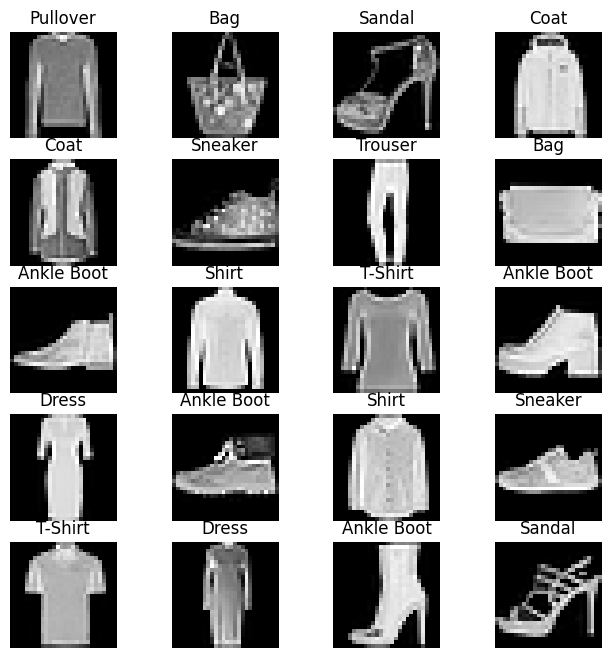

In [5]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
              4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8)) # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4
rows = 5

for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
import numpy as np
print('0~10 임의의 숫자를 출력', np.random.randint(10))
print('1~9 임의의 숫자를 출력', np.random.randint(1, 10))

print('0~1 사이의 정규표준분포 난수를 행렬로 출력(1x8)',np.random.rand(8))

print('0~1 사이의 정규표준분포 난수를 행렬로 출력(4x2)',np.random.rand(4,2))

print('평균이 0이고, 표쥰편차가 1인 가우시안 정규분포 난수를 행렬로 출력',np.random.randn(8))

0~10 임의의 숫자를 출력 4
1~9 임의의 숫자를 출력 7
0~1 사이의 정규표준분포 난수를 행렬로 출력(1x8) [0.09225768 0.40309011 0.16451977 0.64715052 0.66132139 0.41096262
 0.08144374 0.37775161]
0~1 사이의 정규표준분포 난수를 행렬로 출력(4x2) [[0.32701745 0.88598262]
 [0.62470814 0.48894942]
 [0.53588657 0.19318952]
 [0.88287878 0.21832899]]
평균이 0이고, 표쥰편차가 1인 가우시안 정규분포 난수를 행렬로 출력 [-1.03951215 -0.65286459  0.44586685 -1.38923365 -2.34463165 -1.28714994
  0.92656111 -0.5297406 ]


In [8]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

* 클래스(class) 형태의 모델은 항상 `torch.nn.Module`을 상속받습니다. __init__()은 객체가 갖는 속성 값을 초기화하는 역할을 하며, 객체가 생성될 때 자동으로 호출됩니다. super(FashionDNN, self).__init__()은 FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미로 이해하면 됩니다.

* `nn`은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지이며, `Linear`는 단순 선형 회귀 모델을 만들 때 사용합니다. 이때 사용되는 파라미터는 다음과 같습니다.
    ![](../Static/188.jpg)   
        * `in_features` : 입력의 크기(input_size)   
        * `out_features` : 출력의 크기(output_size)   
    실제로 데이터 연산이 진행되는 forward() 부분에는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 forward() 연산의 결과가 됩니다.

* `torch.nn.Dropout(p)`는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에(1/(1-p)) 만큼 곱해져 커집니다. 예를 들어 `p=0.3` 이라는 의미는 전체 값 중 0.3의 확률로 0이 된다는 것이며, 0이 되지 않는 0.7에 해당하는 값은 (1/(1-0.7)) 만큼 커집니다.

* `forward()` 함수는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키며, `반드시 forward`라는 이름의 함수여야 합니다. 즉, forward()는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됩니다. 이때 순전파 연산이란 입력x로부터 예측된 y를 얻는 것입니다.

* 파이토치에서 사용하는 `뷰(view)`는 넘파이의 `reshape`와 같은 역할로 텐서의 크기를 변경해 주는 역할을 합니다. 따라서 `input_data.view(-1, 784)`는 input_data를 (?, 784)의 크기로 변경하라는 의미입니다. 이때 첫 번째 차원은(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미이고, 두 번째 차원의 길이는 784를 가지도록 하라는 의미입니다. 다시 말해 2차원 텐서로 변경하되 (?, 784)의 크기로 변경하라는 의미입니다.

* 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능합니다.
    * `F.relu()`: forward() 함수에서 정의  
    * `nn.ReLU()`: __init__() 함수에서 정의  
    활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용되는 위치라고 할 수 있습니다.

모델을 학습시키기 전에 `손실 함수`, `학습률(lr)`, `옵티마이저(optimizer)`에 대해 정의합니다.

In [9]:
learning_rate = 1e-3
model = FashionDNN()
model.to(device=device)

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


이제 심층 신경망에 데이터를 적용하여 모델을 학습시킵니다.

In [11]:
epochs = 5
count = 0
loss_list = []
iteration_list = []
acuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(epochs - 1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): #count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_laoder:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)

                prediction = torch.max(outputs, 1)[1].to(device)
                prediction_list.append(prediction)
                correct += (prediction == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            acuracy_list.append(accuracy)
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(
                count, loss.data, accuracy))


Iteration: 500, Loss: 0.421601802110672, Accuracy: 86.55999755859375%
Iteration: 1000, Loss: 0.40044310688972473, Accuracy: 86.22000122070312%
Iteration: 1500, Loss: 0.2668381929397583, Accuracy: 87.6199951171875%
Iteration: 2000, Loss: 0.31248152256011963, Accuracy: 87.54999542236328%


* 일반적으로 배열이나 행렬과 같은 리스트(list)를 사용하는 방법은 다음과 같습니다.
    * 비어있는 배열이나 행렬을 만듭니다.   
    * `append` 메서드를 이용하여 데이터를 하나씩 추가합니다.  


* `for` 구문을 사용하여 레코드를 하나씩 가져옵니다. 이때 `for x, y in train:`과 같이 in 앞에 변수를 두 개 지정해주면 레코드에서 요소 두 개를 꺼내 오겠다는 의미입니다.
![](../Static/192.jpg)  

* 모델이 데이터를 처리하기 위해서는 `모델과 데이터`가 동일한 장치 (CPU 또는 GPU)에 있어야합니다. `model.to(device)`가 GPU를 사용했다면, `images.to(device)`, `labels.to(device)`도 GPU에서 처리되어야 합니다. 참고로 CPU에서 처리된 데이터를 GPU 모델에 적용하거나 그 반대의 경우 런타임 오류가 발생합니다.

* `Autograd`는 자동 미분을 수행하는 파이토치의 핵심 패키지로, 자동 미분에 대한 값을 저장하기 위해 테이프(tape)를 사용합니다. 순전파(forward) 단계에서 테이프는 수행하는 모든 연산을 저장합니다. 그리고 역전파(backward) 단계에서 저장된 값들을 꺼내서 사용합니다. 즉, Autograd는 `Variable`을 이용해서 역전파를 위한 미분 값을 자동으로 계산해 줍니다. 따라서 자동 미분을 계산하기 위해서는 `torch.autograd` 패키지 안에 있는 `Variable`을 이용해야 동작합니다.

* 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있으며, 코드는 다음과 같습니다.  
```py
classification_accuracy = correct predictions / total predictions
```


최종적으로 정확도가 86% 로 높은 수치를 보여 줍니다. 심층 신경망에 대한 모델 생성과 성능을 평가해 보았다면, 이제 합성곱 신경망을 생성해 보겠습니다.

In [16]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self) -> None:
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10) # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
        

* `nn.Sequential`을 사용하면 __init__() 에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라, `forward()` 함수에서 구현될 순전파를 계층(layer) 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있습니다. 즉 `nn.Sequential`은 계층을 차례로 쌓을 수 있도록 Wx+b 와 같은 수식과 활성화 함수를 연결해 주는 역할을 합니다. 특히 데이터가 각 계층을 순차적으로 지나갈 때 사용하면 좋은 방법입니다. 정리하면 `nn.Sequential`은 여러 개의 계층을 하나의 컨테이너에 구현하는 방법이라고 생각하면 됩니다.

* `합성곱층(Conv layer)`은 합성곱 연산을 통해서 이미지의 특징을 추출합니다. 합성곱이란 커널(또는 필터)라는 n x m 크기의 행렬이 높이 x 너비 크기의 이미지를 처음부터 끝까지 훑으면서 각 원소 값끼리 곱한 후 모두 더한 값을 출력합니다. 커널은 일반적으로 3 x 3 이나 5 x 5를 사용하며 파라미터는 다음과 같습니다.  
![](../Static/194.jpg)  

`in_channels` : 입력 채널의 수를 의미합니다. 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많습니다.  
`out_channels` : 출력 채널의 수를 의미합니다.  
`kernel_size` : 커널 크기를 의미하며 논문에 따라 필터라고도 합니다. 커널은 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 필터 파라미터가 됩니다. 커널은 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산합니다.  

참고로 `kernel_size=3`이라고 했을때, 커널의 크기는 (3,3)으로 정사각형을 의미하며 직사각형을 사용하고 싶다면 (3,5)처럼 저장합니다.  

`padding` : 패딩 크기를 의미하는 것으로 출력 크기를 조절학 위해 입력 데이터 주위에 0을 채웁니다. 패딩 값이 클수록 출력 크기도 커집니다.

* `BatchNorm2d` 는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미합니다. 다음 그림을 보면 배치 단위나 계층에 따라 입력 값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만듭니다. 그러면 평균은 0, 표준편차는 1로 데이터의 분포가 조정됩니다.  

![](../Static/195_2.jpg)

* `MaxPool2d`는 이미지 크기를 축소시키는 용도로 사용합니다. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용됩니다. 풀링 계층을 처리하는 방법으로는 `최대 풀링(max pooling)`과 `평균 풀링(average pooling)`,`최소 풀링(min pooling)`이 있으며, 이때 사용하는 ㅏ라미터는 다음과 같습니다.
    * `kernel_size` : m x n 행렬로 구성된 가중치

    * `stride` : 입력 데이터에 커널(필터)을 적용할 때 이동할 간격을 의미하는데, 스트라이드 값이 커지면 출력 크기는 작아집니다.

* 클래스를 분류하기 위해서는 이미지 형태의 데이터를 배열 형태로 변환하여 작업해야 합니다. 이때 `Conv2d`에서 사용하는 하이퍼파라미터 값들에 따라 출력 크기(output size)가 달라집니다. 즉, 패딩과 스트라이드의 값에 따라 출력 크기가 달라집니다. 이렇게 줄어든 출력 크기는 최종적으로 `분류를 담당하는 완전연결층(fully connected layer)`으로 전달됩니다.

이번에는 합성곱 네트워크를 사용하기 위한 파라미터를 정의합니다.

In [17]:
learning_rate = 1e-3
model = FashionCNN()
model.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [18]:
epochs = 5
count = 0
loss_list = []
iteration_list = []
acuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(epochs - 1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50): #count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_laoder:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)

                prediction = torch.max(outputs, 1)[1].to(device)
                prediction_list.append(prediction)
                correct += (prediction == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            acuracy_list.append(accuracy)
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(
                count, loss.data, accuracy))

c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.46870744228363037, Accuracy: 87.8499984741211%
Iteration: 1000, Loss: 0.32263660430908203, Accuracy: 87.33999633789062%
Iteration: 1500, Loss: 0.30235543847084045, Accuracy: 88.16999816894531%
Iteration: 2000, Loss: 0.16942773759365082, Accuracy: 88.93999481201172%


심층 신경망과 비교하여 정확도가 약간 높습니다. 심층 신경망과 별 차이가 없기 때문에 좀 더 간편한 심층 신경망만 사용해도 무난할 것 같지만 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 합성곱 신경망을 생성할 수 있도록 학습해야 합니다.